In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 6)
import random
random.seed(0)

# Probabilistic programming from scratch

> This article contains highlights from a series of [three interactive video tutorials](https://www.safaribooksonline.com/search/?query=%22Probabilistic%20Programming%20from%20Scratch%22&extended_publisher_data=true&highlight=true&is_academic_institution_account=false&source=user&include_assessments=false&include_courses=true&include_orioles=true&include_playlists=true&publishers=O%27Reilly%20Media%2C%20Inc.&field=title&sort=relevance&utm_source=oreilly&utm_medium=newsite&utm_campaign=probabilistic-programming-from-scratch-top-cta-orioles-link) on probabilistic programming from scratch published on O'Reilly Safari (login required).
>
> If you're interested in the business case for probabilistic programming the [Fast Forward Labs report](http://blog.fastforwardlabs.com/2017/01/18/new-research-on-probabilistic-programming.html) discusses it in detail, and compares modern industrial strength systems like Stan and PyMC3. Please [get in touch](http://www.fastforwardlabs.com/#contact) if you're interested in working with us.
>
> This article is [available as a Jupyter Notebook](https://github.com/fastforwardlabs/probabilistic-programming-from-scratch/blob/master/probabilistic-programming-from-scratch.ipynb).

Real-world data is almost always incomplete or inaccurate in some way. This means that the uncertain conclusions we draw from it are only meaningful if we can answer the question: how uncertain?

One way to do this is using Bayesian inference. But, while Bayesian inference is conceptually simple, it can be analytically and computationally difficult in practice. Probabilistic programming is a paradigm that abstracts away some of this complexity.

There are many probabilistic programming systems. Perhaps the most advanced is [Stan](http://mc-stan.org/), and the most accessible to non-statistician programmers is [PyMC3](https://pymc-devs.github.io/pymc3/). At Fast Forward Labs we recently shared with our clients a [detailed report on the technology and uses of probabilistic programming in startups and enterprises](http://blog.fastforwardlabs.com/2017/01/18/new-research-on-probabilistic-programming.html).

But in this article, rather than use either of these advanced comprehensive systems, we're going to build our own extremely simple system from scratch.

We'll write clear, functional Python 3. We'll use generators to build up a pipeline that will allow us to answer concrete questions. We won't use any libraries (except for random number generation and plotting). And I'll go easy on the mathematics. The code will be slow compared to Stan and PyMC3, but hopefully you'll understand every line.

This "from scratch" approach follows in the footsteps of Joel Grus's book [Data Science from Scratch](http://shop.oreilly.com/product/0636920033400.do), and Jake
VanderPlas's PyCon talk [Statistics for Hackers](https://www.youtube.com/watch?v=Iq9DzN6mvYA). I recommend both! In his talk, Jake said, "if you can write a for loop, you can do statistical analysis". That isn't always true (good luck implementing [ADVI](https://arxiv.org/abs/1603.00788) with a for loop). But when it is true, we can focus on the big, fundamental ideas without getting lost in algebraic or computational details.

## An A/B test

Let's take a specific data analysis problem: a simple A/B test for a website. Suppose our site has two layouts. During our test, 4% of visitors to layout A convert (i.e., buy something, sign up for the mailing list, whatever), and 5% to layout B convert. Clearly, layout B is better, so we should use that layout, right?

But what if I tell you it was a very small test?

In [2]:
n_visitors_a = 100  # number of visitors shown layout A
n_conv_a = 4        # number of vistors shown layout A who converted

n_visitors_b = 40
n_conv_b = 2

Are you still sure B is better? And what if it's going to cost us $1 million to change the layout if we get this decsion wrong. Are you sure enough? If not, how much more data would you need?

To answer these questions, we need to quantify exactly how confident we are that layout B is better, given the slice of data we do have.

## A simple algorithm for Bayesian inference

We can do that using Bayesian inference. Bayesian inference is a method for updating your knowledge about the world with the information you learn during an experiment. It derives from a simple equation called Bayes's Rule. In its most advanced and efficient forms, it can be used to solve huge problems. But we're going use a specific, simple inference algorithm called Approximate Bayesian Computation (ABC), which is barely a couple of lines of Python:

In [3]:
def posterior_sampler(data, prior_sampler, simulate):
    '''Yield samples from the posterior by Approximate Bayesian Computation.'''
    for p in prior_sampler:
        if simulate(p) == data:
            yield p

This function turns the _prior_ distribution into the _posterior_. What does that mean?

I talk about these distributions in more detail in [the video tutorials](https://www.safaribooksonline.com/search/?query=%22Probabilistic%20Programming%20from%20Scratch%22&extended_publisher_data=true&highlight=true&is_academic_institution_account=false&source=user&include_assessments=false&include_courses=true&include_orioles=true&include_playlists=true&publishers=O%27Reilly%20Media%2C%20Inc.&field=title&sort=relevance&utm_source=oreilly&utm_medium=newsite&utm_campaign=probabilistic-programming-from-scratch-top-cta-orioles-link), but for this article, the rough idea is sufficient: samples from the prior distribution are our best guesses of the values of the unknown parameter of our system. In the case of an A/B test, this is the conversion fraction of a layout. These guesses are made before we do the experiment.

Samples from the posterior distribution, meanwhile, are guesses of the same parameters made _after_ the experiment, in the light of the data we gathered. Once you have the posterior, you can answer concrete questions about the implications of the data, such as how likely it is that layout B is better, given our data.

In the function above, the `prior_sampler` argument is a generator that yields samples from the prior. We run the function `simulate` on a single sample from the prior. This _simulates_ the experiment, _assuming_ the prior sample is correct. We then compare the simulated outcome to the real outcome (`data`). If these agree, the sample from the prior can be used as a sample from the posterior. If not, we try again with another sample from the prior, until they do agree.

After we run a lot of simulations using lots of samples from the prior, we'll have a good idea of which values were most likely to produce the observations we in fact saw, and are therefore most likely to be correct.

## Using the sampler

And that's the whole algorithm. Abstracted away in that little `posterior_sampler` generator function, it's an extremely lightweight probabilistic programming system.

Let's use it to finish our A/B test, starting with layout A. We need to prepare three arguments: `data`, `prior_sampler` and `simulate`. We already have the `data` for our A/B test. Let's now write a function that simulates the conversion of `n_visitors` visitors to a website with known probability `p`:

In [4]:
import random

def simulate_conversion(p, n_visitors):
    '''Return number of vistors who convert, given conversion fraction p.'''
    outcomes = (random.random() < p for i in range(n_visitors))
    return sum(outcomes)

Here's what happens when we run this function a few times to simulate 100 visitors converting with probability 0.1:

In [5]:
simulate_conversion(0.1, 100), simulate_conversion(0.1, 100), simulate_conversion(0.1, 100)

(5, 11, 12)

Effectively, this function runs a fake A/B test in which we already know the conversion fraction. Here's how it works. The `random` function returns a random floating point number between 0 and 1. That number will be smaller than `p` with probability equal to `p`. We use a generator expression to do this `n_visitors` times. `outcomes` is then an iterable of booleans, `True` if that trial was a success (i.e. the ith visitor converted) and `False` if not. Finally we take advantage of the fact that the `sum` of an iterable of booleans is equal to the number of `True` elements it contains. 

We use a generator comprehension in this function because `n_visitors` could potentially be very large, and we want to do these calculations lazily and avoid holding the
outcome for each visitor in memory simultaneously. (If Python generators are new to you, I recommend you [watch](https://www.youtube.com/watch?v=EnSu9hHGq5o) or [read](https://nedbatchelder.com/text/iter.html) Ned Batchelder's fantastic PyCon 2013 talk, "How To Loop Like a Native" for an introduction. If you're not using generators, you're not using the full power of Python. I talk about them much more in the video tutorials.)

Finally we need `prior_sampler`. This should be a generator that yields a large (potentially infinite) number of guesses for the conversion fraction of a layout. Suppose we've never used layout A. Logically we know that it must be somewhere between 0 and 100%, but other than that we have no idea. This generator captures that idea:

In [6]:
def uniform_prior_sampler():
    '''Yield random numbers in interval (0, 1).'''
    while True:
        yield random.random()

Let's write a quick `take` function that will allow us to peek at a few samples from this generator.

In [7]:
import itertools

def take(n, iterable):
    "Return first n items of the iterable as a list."
    return list(itertools.islice(iterable, n))

We can use this to draw 3 samples from our "uniform" prior sample like this:

In [8]:
take(3, uniform_prior_sampler())

[0.8943997782145745, 0.9196888444316101, 0.6267420468068673]

Now we're ready to run `posterior_sampler` to create an object that will
yield up samples from the posterior distribution for layout A's conversion
fraction:

In [9]:
posterior_a_sampler = posterior_sampler(
    data=n_conv_a,
    prior_sampler=uniform_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, n_visitors_a)
)

(The `lambda` function here bakes in the number of visitors for layout A into the simulate argument. This is "partial eveluation". We could also have used `functools.partial` for this.)

To get a few samples from the posterior, we can use `take` again:

In [10]:
take(3, posterior_a_sampler)

[0.03810094949124154, 0.067278098392767, 0.05786540496383208]

These are three guesses for the unknown conversion fraction of layout A. They are all around 4% percent. That's consistent with the fact that we had four conversions from 100 visitors. But note they are not exactly 4%. We can build up a picture of their distribution by getting thousands of samples from `posterior_sampler` and plotting a histogram.

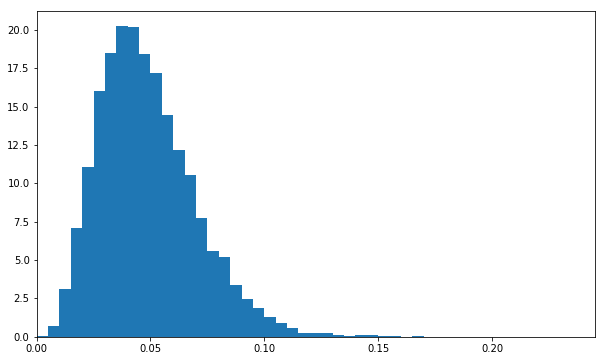

In [11]:
a_samples = take(10000, posterior_a_sampler)

abbins = [i/200.0 for i in range(50)]          # 50 bins between 0 and 0.25
plt.hist(a_samples, bins=abbins, normed=True)  # normed=True gives a probability density function
plt.xlim(0, max(abbins));

This is the posterior distribution for the conversion fraction of layout A. It's a full picture of our knowledge after the experiment.

The posterior distribution is the object we use to answer concrete questions about our knowledge after an experiment. We can, for example, use this one to say how likely it is that layout A's conversion fraction is greater than 10%. We can do this by measuring the fraction of `a_samples` for which that is true:

In [12]:
sum(a > 0.1 for a in a_samples)/len(a_samples)

0.0202

Again, we're using the fact that the sum of an iterable of booleans is equal the number of true elements.

This tells us there's a 2% chance layout A's conversion fraction is greater than 10% (or equivalently, we can be 98% certain it's less than 10%).

## Completing the A/B test

To complete the A/B test, however, we also need the posterior for layout B.

Let's suppose that layout B is not brand new. We do have a rough idea of its conversion fraction before we conduct the experiment. Perhaps we think it's 6%, plus or minus a couple of per cent. In this case, uniform_prior_sampler is not appropriate, but something like this would work well:

In [13]:
def normal_prior_sampler(mu=0.06, sigma=0.02):
    '''Yield stream of samples from N(mu, sigma) in interval (0, 1).'''
    while True:
        x = random.normalvariate(mu, sigma)
        if 0 <= x <= 1:
            yield x

Mathematically, this function samples from a normal distribution with a known mean and standard deviation, and support in the interval (0, 1). Conceptually, though, it's easier to plot a histogram, and compare this prior to the uniform prior we used for layout A.

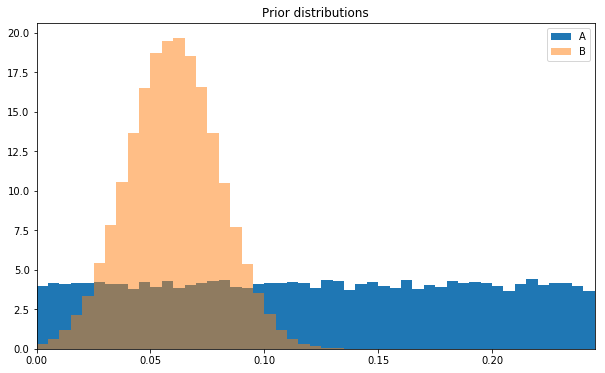

In [14]:
plt.hist(take(100000, uniform_prior_sampler()), bins=abbins, label='A', normed=True)
plt.hist(take(100000, normal_prior_sampler()), bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Prior distributions')
plt.xlim(0, max(abbins))
plt.legend();

The guesses for layout B are concentrated around 6%, which captures our prior knowledge.

Now we have the prior sampler for layout B we can make its posterior sampler and take some samples.

In [15]:
posterior_b_sampler = posterior_sampler(
    data=n_conv_b,
    prior_sampler=normal_prior_sampler(),
    simulate=lambda p: simulate_conversion(p, n_visitors_b)
)
b_samples = take(10000, posterior_b_sampler)

Let's visualize the two sets of posterior samples directly.

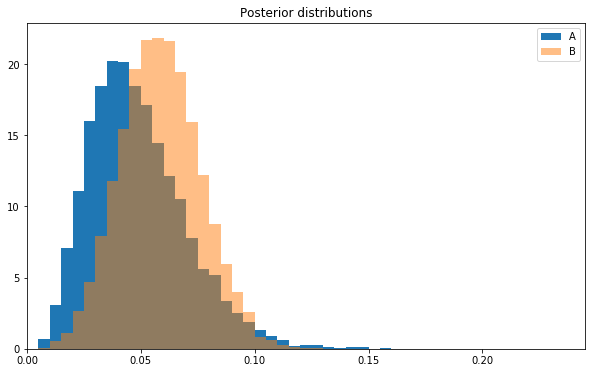

In [16]:
plt.hist(a_samples, bins=abbins, label='A', normed=True)
plt.hist(b_samples, bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Posterior distributions')
plt.xlim(0, max(abbins));
plt.legend();

Note the histogram for layout B is to the right of that for layout A. This is telling us that layout B is probably better than layout A.

And we're finally in a position to answer the original question: how confident can we be that layout B is better?

In this simple case, we can do this by making pairwise comparisons between the two lists of estimates and measuring the fraction of pairs for which the estimated conversion fraction of B is bigger than that for A.

In [17]:
sum(b > a for a, b in zip(a_samples, b_samples))/len(a_samples)

0.659

And that's it! Given the data and our prior beliefs, we are 66% sure that layout B is better than A.

If a mistake is going to cost us $1 million, this probably isn't confident enough. We need to run a bigger A/B test before making this business decision. If we collect more data, however, we'll quickly run into one of the limitations of ABC: it's slow. Change the data and rerun this code to see for yourself.

Approximate Bayesian Computation is slow and in some ways crude. There are often [better options](http://blog.fastforwardlabs.com/2017/01/30/the-algorithms-behind-probabilistic-programming.html). But it's not cheating. In the tutorials, I show how to speed it up for more realistic problems.

## Next steps

This article hopefully helped you to form a mental model of the relationship between the prior and the posterior distributions. This should leave you in good shape to look deeper into probabilistic programming and inference. 

Log in to O'Reilly Safari and check out the three tutorials for a deeper video and text discussion, interactive code examples, exercises, and ideas for where to go next:

 - [Part 1: A/B Testing with Approximate Bayesian Computation](https://www.safaribooksonline.com/oriole/probabilistic-programming-from-scratch-1-a-b-testing-with-approximate-bayesian-computation)
 - [Part 2: Bayes' Theorem and Online Learning](https://www.safaribooksonline.com/oriole/probabilistic-programming-from-scratch-2-bayes-theorem-and-online-learning)
 - [Part 3: Improving Algorithmic Performance and PyMC3](https://www.safaribooksonline.com/oriole/probabilistic-programming-from-scratch-3-improving-algorithmic-performance-and-online-learning)

The [Fast Forward Labs report](http://blog.fastforwardlabs.com/2017/01/18/new-research-on-probabilistic-programming.html), meanwhile, discusses the business case for probabilistic programming in detail, and compares modern industrial strength systems like Stan and PyMC3. Please [get in touch](http://www.fastforwardlabs.com/#contact) if you're interested in working with us.